# Deploy the model and evaluate the metrics

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import randint
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Assume you already have a dataframe 'df' with the columns mentioned above
df = pd.read_csv('cleaning_data.csv')

# Create new features
df['Study_and_Sleep'] = df['Hours_Studied'] * df['Sleep_Hours']
df['Study_to_Attendance'] = df['Hours_Studied'] / (df['Attendance'] + 1)

# Data processing:
# Divide columns into numerical and categorical types
numeric_cols = ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity', 'Study_and_Sleep', 'Study_to_Attendance']
categorical_cols = ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 
                    'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 
                    'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']
# numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
# categorical_cols = df.select_dtypes(include=['object']).columns

# Create a Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Separate features and target labels
X = df.drop(columns=['Exam_Score'])
y = df['Exam_Score']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a Pipeline with Preprocessing and RandomForest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# Quick model tuning with RandomizedSearchCV
param_dist = {
    'model__n_estimators': randint(100, 500),
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['auto', 'sqrt', 'log2']
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=50, cv=5, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Results
print(f'Best parameters: {random_search.best_params_}')
print(f'Best cross-validation score: {random_search.best_score_}')

# Predict using the best model
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f'Best Model Mean Squared Error: {mse_best}')
print(f'Best Model Mean Absolute Error: {mae_best}')
print(f'Best Model R2: {r2_best}')

# Evaluate the model with cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(pipeline, X, y, cv=cv, n_jobs=-1)
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean CV score: {cv_scores.mean()}')


Best parameters: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 233}
Best cross-validation score: 0.6256637360498774
Best Model Mean Squared Error: 4.509250352630925
Best Model Mean Absolute Error: 1.1074468282047125
Best Model R²: 0.6809885226109421
Cross-validation scores: [0.58746953 0.65627197 0.66712501 0.65656013 0.58189778]
Mean CV score: 0.6298648835878671


# Graphs

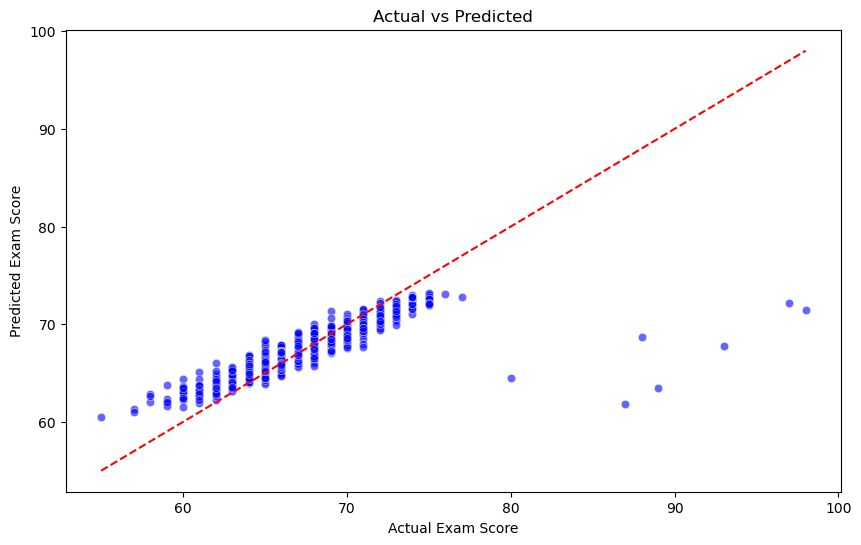

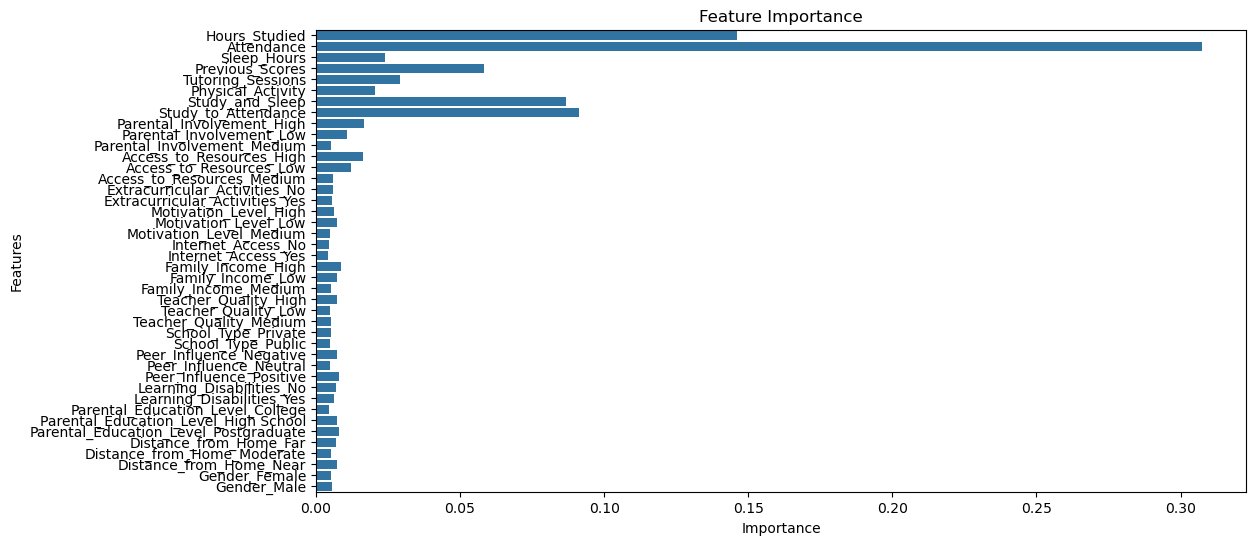

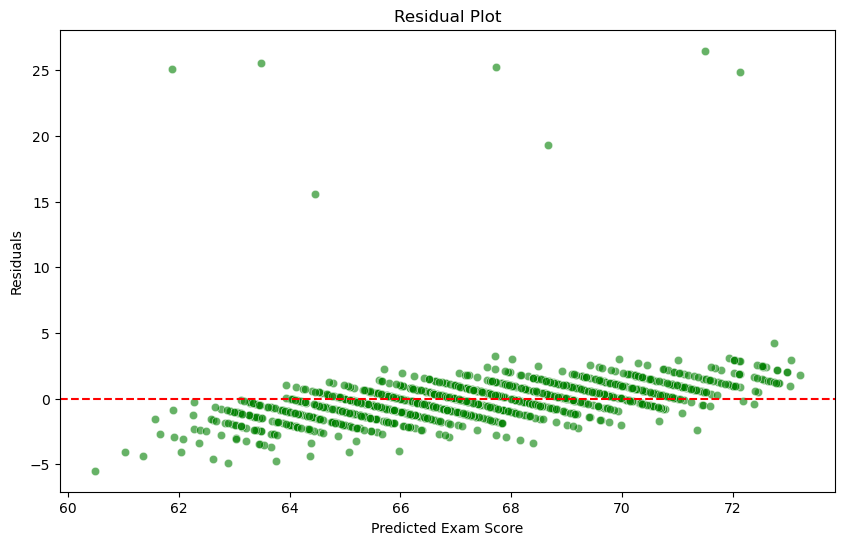

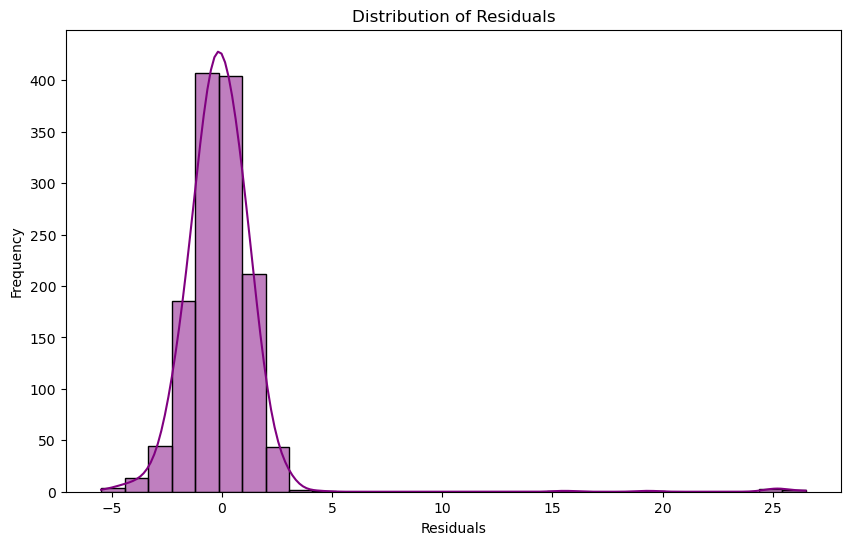

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plot the distribution of actual and predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_best, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Diagonal line (y=x)
plt.title('Actual vs Predicted')
plt.xlabel('Actual Exam Score')
plt.ylabel('Predicted Exam Score')
plt.show()

# Plot the importance of features (Feature Importance)
feature_importance = best_model.named_steps['model'].feature_importances_
features = numeric_cols + list(best_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols))

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance, y=features)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Plot residuals (Residual Plot)
residuals = y_test - y_pred_best

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_best, y=residuals, color='green', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Exam Score')
plt.ylabel('Residuals')
plt.show()

# Plot the distribution of residuals (Distribution of Errors)
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='purple', bins=30)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


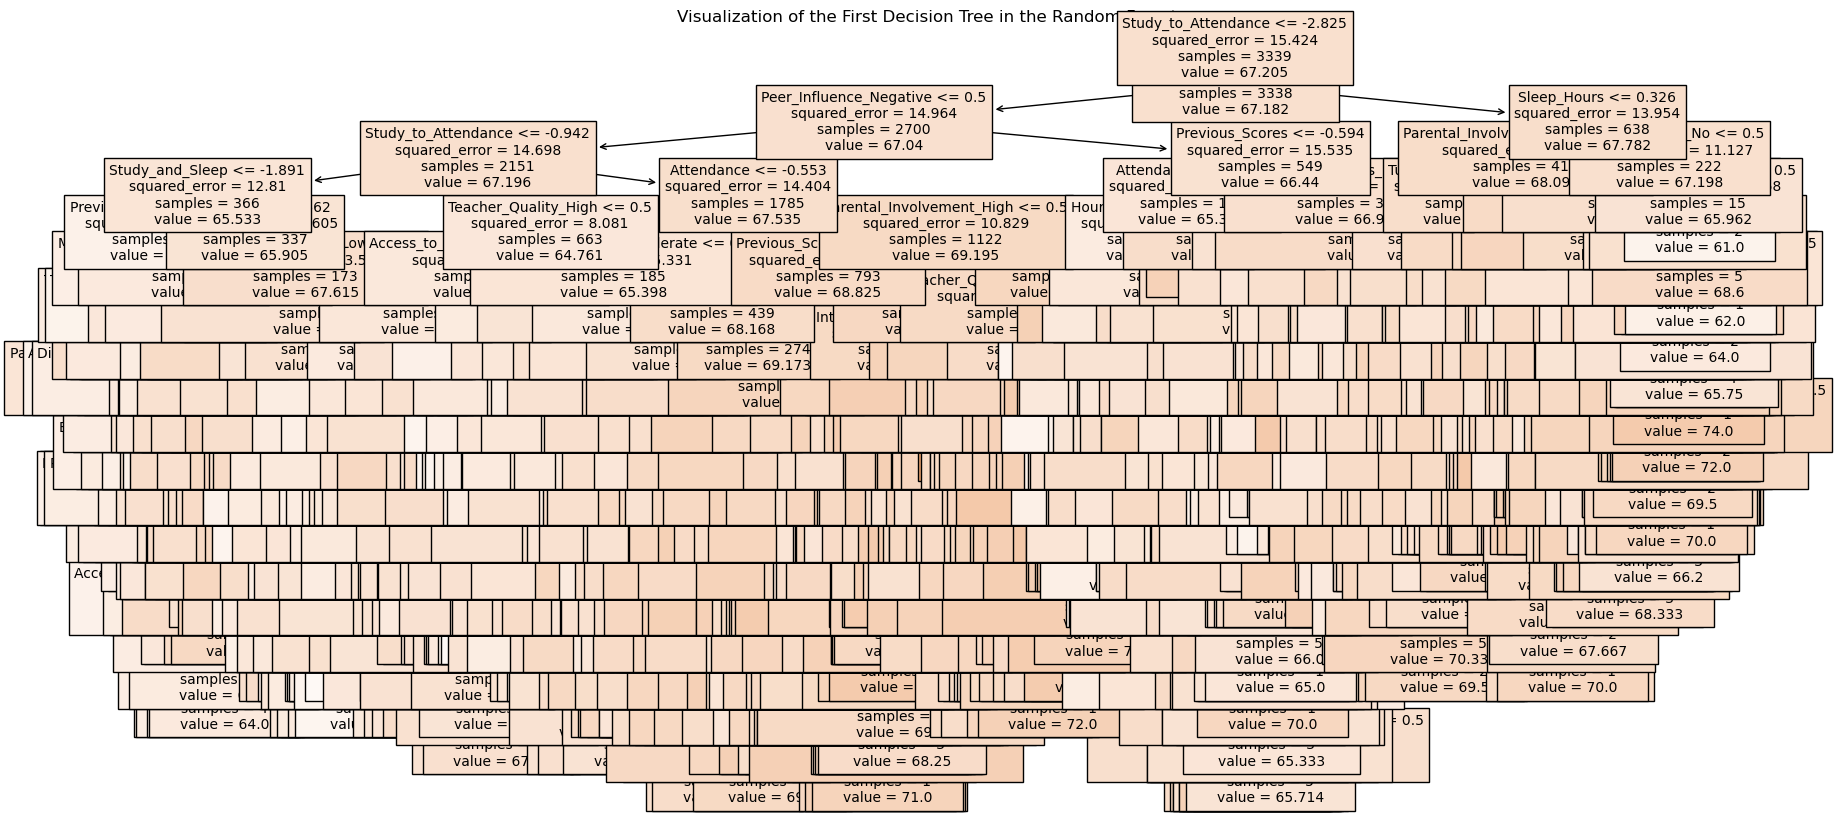

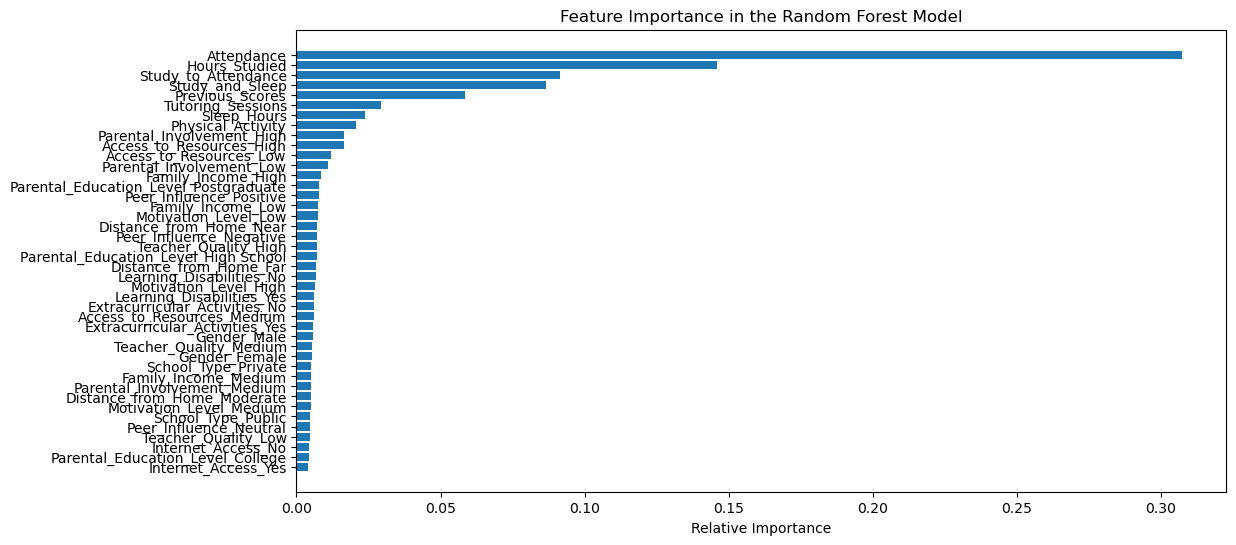

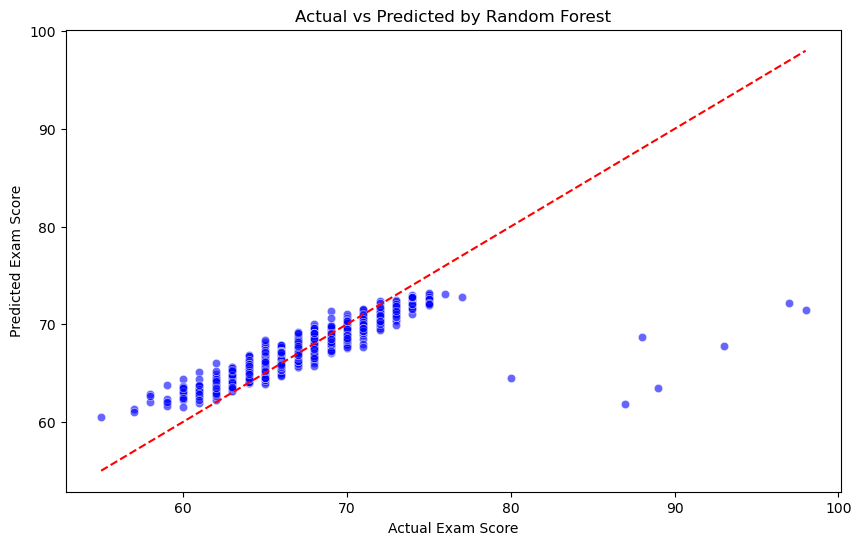

In [17]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Select the first decision tree in the forest
tree = best_model.named_steps['model'].estimators_[0]

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=features, fontsize=10)
plt.title('Visualization of the First Decision Tree in the Random Forest')
plt.show()

# Extract feature importances
importances = best_model.named_steps['model'].feature_importances_

# Sort features by decreasing importance
indices = np.argsort(importances)

# Plot the feature importance
plt.figure(figsize=(12, 6))
plt.title('Feature Importance in the Random Forest Model')
plt.barh(range(len(importances)), importances[indices], align='center')
plt.yticks(range(len(importances)), np.array(features)[indices])
plt.xlabel('Relative Importance')
plt.show()

# Predict using the Random Forest model
y_pred_rf = best_model.predict(X_test)

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Diagonal line (y=x)
plt.title('Actual vs Predicted by Random Forest')
plt.xlabel('Actual Exam Score')
plt.ylabel('Predicted Exam Score')
plt.show()
